In [1]:
!pip install ucimlrepo pandas numpy scikit-learn matplotlib seaborn xgboost tensorflow joblib plotly

In [2]:
import os
import time
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML & DL Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Config & Directory Setup
BASE_DIR = Path(os.getcwd())
if BASE_DIR.name in ['notebooks', 'src']:
    BASE_DIR = BASE_DIR.parent

DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"
IMAGES_DIR = BASE_DIR / "images"

for d in [DATA_DIR, MODELS_DIR, IMAGES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {BASE_DIR}")
print(f"Data Dir: {DATA_DIR}")
print(f"Models Dir: {MODELS_DIR}")
print(f"Images Dir: {IMAGES_DIR}")

# Seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

def save_plot(fig, filename):
    path = IMAGES_DIR / filename
    fig.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Plot saved: {path}")

def regression_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(float).flatten()
    y_pred = np.array(y_pred).astype(float).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

Project Root: /content
Data Dir: /content/data
Models Dir: /content/models
Images Dir: /content/images


In [3]:
# @title DATA LOADING
print("Loading Dataset.")
try:
    from ucimlrepo import fetch_ucirepo
    ds = fetch_ucirepo(id=849)
    X_raw = ds.data.features.copy()
    y_raw = ds.data.targets.copy()

    df = pd.concat([X_raw, y_raw], axis=1)
    df.to_csv(DATA_DIR / "tetouan_power_raw.csv", index=False)
    print(ds.metadata)
    print(ds.variables)
    print("Dataset loaded and saved backup.")

except ImportError:
    print("Please install ucimlrepo: pip install ucimlrepo")
    raise

Loading Dataset.
{'uci_id': 849, 'name': 'Power Consumption of Tetouan City', 'repository_url': 'https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city', 'data_url': 'https://archive.ics.uci.edu/static/public/849/data.csv', 'abstract': 'This dataset is related to power consumption of three different distribution networks of Tetouan city which is located in north Morocco.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 52417, 'num_features': 6, 'feature_types': ['Real', 'Integer'], 'demographics': [], 'target_col': ['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C5B034', 'creators': ['Abdulwahed Salam', 'Abdelaaziz El Hibaoui'], 'intro_paper': {'ID': 260, 'type': 'NATIVE', 'title': 'Comp

In [4]:
X_raw.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085


In [5]:
#@title Jumlah Data yang dimiliki (N)

# jumlah data dari fitur
print("Jumlah data dari fitur:", X_raw.shape[0])

# jumlah data dari label
print("Jumlah data dari target:", y_raw.shape[0])

Jumlah data dari fitur: 52416
Jumlah data dari target: 52416


Data Preparation & EDA
Target Column: Zone 1 Power Consumption
Generating Lag Features
Dropped 24 rows due to lag creation.
Final Data Shape: (52392, 13)
Plot saved: /content/images/eda_target_distribution.png


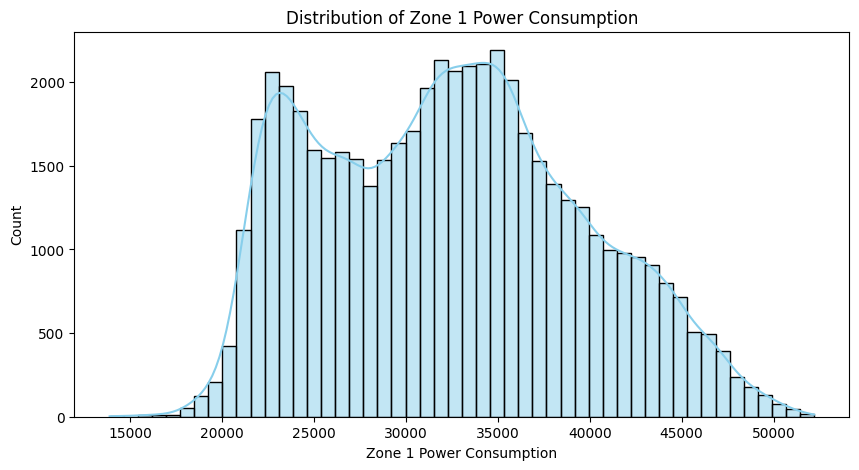

Plot saved: /content/images/eda_correlation_heatmap.png


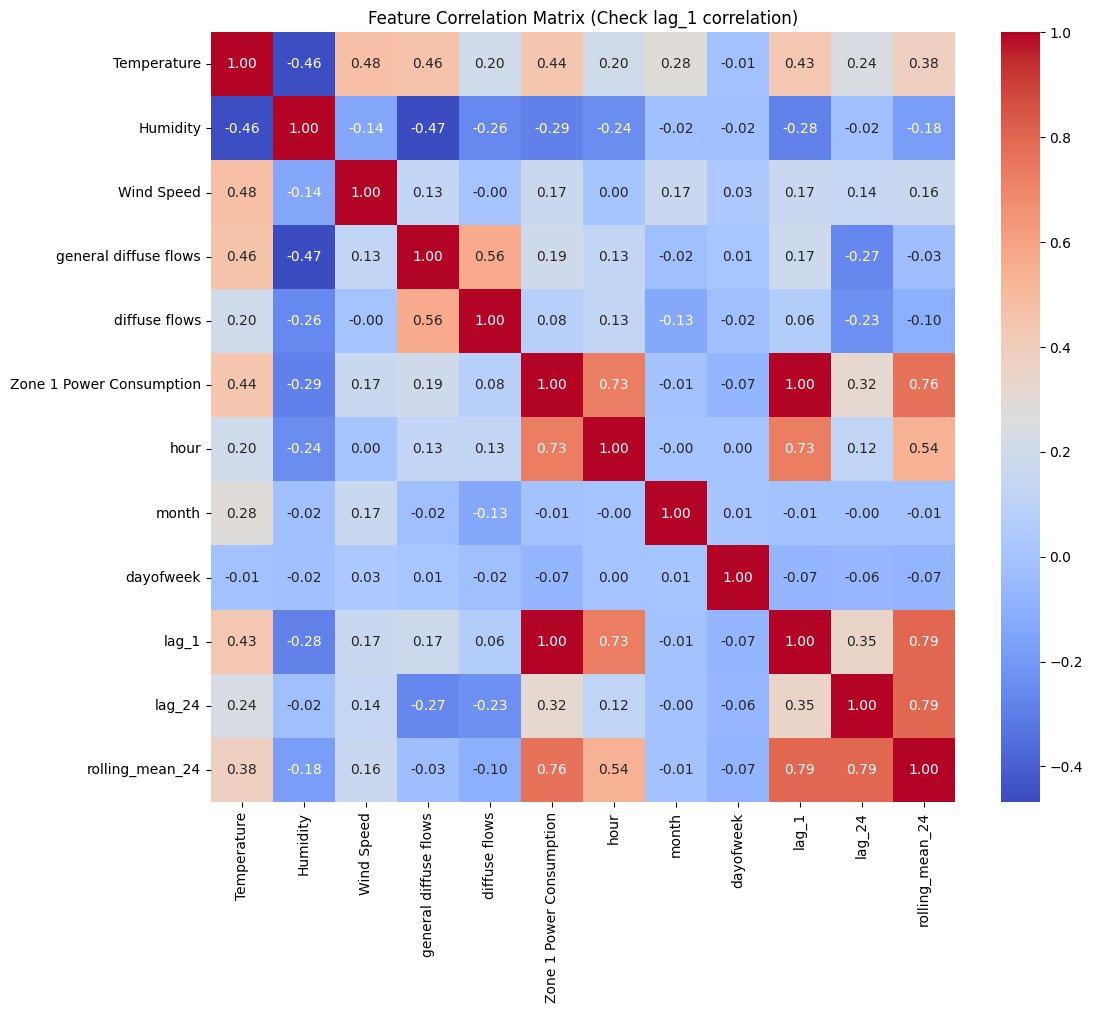

In [6]:
# @title DATA PREPARATION, EDA, dan FEATURE ENGINEERING
print("Data Preparation & EDA")

# Identifikasi Target (Zone 1)
target_col = [c for c in df.columns if 'zone' in str(c).lower() and '1' in str(c).lower()][0]
print(f"Target Column: {target_col}")

# Datetime Handling
datetime_col = "DateTime"
df[datetime_col] = pd.to_datetime(df[datetime_col])
df = df.sort_values(datetime_col).reset_index(drop=True)

# Feature Engineering
df['hour'] = df[datetime_col].dt.hour
df['month'] = df[datetime_col].dt.month
df['dayofweek'] = df[datetime_col].dt.dayofweek

# Lag Features
print("Generating Lag Features")

# Apa yang terjadi 1 jam lalu?
df['lag_1'] = df[target_col].shift(1)

# Apa yang terjadi jam saat ini waktu kemarin?
df['lag_24'] = df[target_col].shift(24)

# Rata-rata konsumsi 24 jam terakhir
df['rolling_mean_24'] = df[target_col].shift(1).rolling(window=24).mean()

# Hapus baris kosong (NaN) yang muncul akibat shifting (24 data pertama akan hilang)
original_len = len(df)
df.dropna(inplace=True)
print(f"Dropped {original_len - len(df)} rows due to lag creation.")
# ----------------------------------------

# Hapus kolom leakage
# Hapus Zone 2 dan Zone 3
drop_cols = [c for c in df.columns if 'zone' in str(c).lower() and c != target_col]
df_clean = df.drop(columns=drop_cols)

print(f"Final Data Shape: {df_clean.shape}")

# EDA Visualization
plt.figure(figsize=(10, 5))
sns.histplot(df_clean[target_col], bins=50, kde=True, color='skyblue')
plt.title(f"Distribution of {target_col}")
save_plot(plt.gcf(), "eda_target_distribution.png")
plt.show()

plt.figure(figsize=(12, 10))
numeric_df = df_clean.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix (Check lag_1 correlation)")
save_plot(plt.gcf(), "eda_correlation_heatmap.png")
plt.show()

In [7]:
# @title SPLITTING & SCALING
print("Splitting & Scaling")

X = df_clean.drop(columns=[target_col, datetime_col])
y = df_clean[target_col]

# Chronological Split
train_size = int(len(X) * 0.8)
X_train_full, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_full, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Validation Split
val_size = int(len(X_train_full) * 0.1)
X_train = X_train_full.iloc[:-val_size]
y_train = y_train_full.iloc[:-val_size]
X_val = X_train_full.iloc[-val_size:]
y_val = y_train_full.iloc[-val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, MODELS_DIR / "scaler.pkl")

Splitting & Scaling
Train: (37722, 11), Val: (4191, 11), Test: (10479, 11)


['/content/models/scaler.pkl']

# Modeling

[Model 1] Training Linear Regression (Baseline)
Linear Regression Training Time: 0.05 seconds
Linear Regression RMSE         : 456.53
Linear Regression MAE          : 290.28
Linear Regression R2 Score     : 0.99
Plot saved: /content/images/model_lr_actual_vs_pred.png


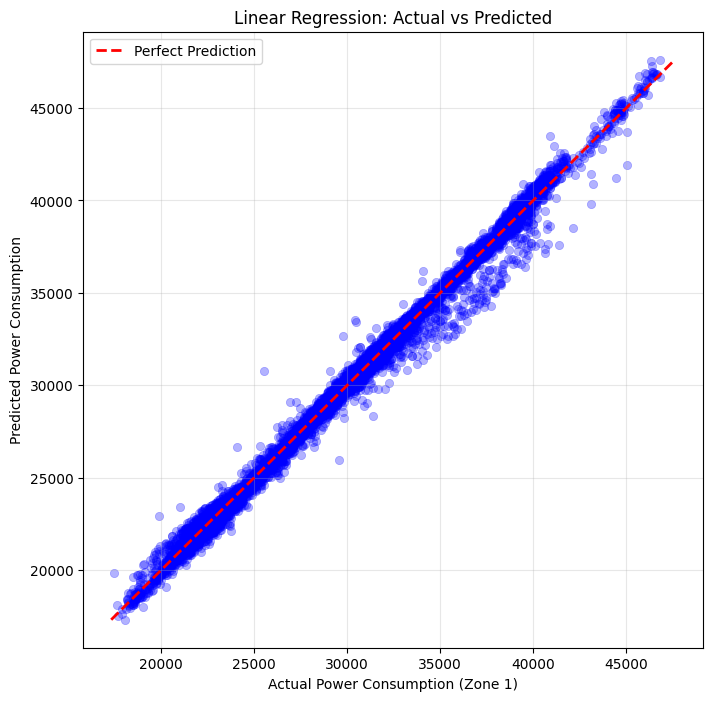

In [8]:
# @title MODEL 1: BASELINE (Linear Regression)
results = {}

print("[Model 1] Training Linear Regression (Baseline)")

# Inisialisasi Model
lr = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None
)

# Hitung Waktu Training
start_time_lr = time.time()
lr.fit(X_train_scaled, y_train)
train_time_lr = time.time() - start_time_lr

# Prediksi
y_pred_lr = lr.predict(X_test_scaled)

# Evaluasi
metrics_lr = regression_metrics(y_test, y_pred_lr)

metrics_lr['Training Time'] = train_time_lr

results['Baseline_LR'] = metrics_lr
joblib.dump(lr, MODELS_DIR / "model_baseline.pkl")

print(f"Linear Regression Training Time: {train_time_lr:.2f} seconds")
print(f"Linear Regression RMSE         : {metrics_lr['RMSE']:.2f}")
print(f"Linear Regression MAE          : {metrics_lr['MAE']:.2f}")
print(f"Linear Regression R2 Score     : {metrics_lr['R2']:.2f}")

# Visualisasi
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3, color='blue', edgecolor=None)
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Power Consumption (Zone 1)')
plt.ylabel('Predicted Power Consumption')
plt.legend()
plt.grid(True, alpha=0.3)

save_plot(plt.gcf(), "model_lr_actual_vs_pred.png")
plt.show()

[Model 2] Tuning Random Forest with RandomizedSearchCV
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuning finished in 208.47 seconds.
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
------------------------------
Random Forest RMSE    : 847.08
Random Forest MAE     : 658.48
Random Forest R2 Score: 0.98
------------------------------
Plot saved: /content/images/model_rf_feature_importance.png


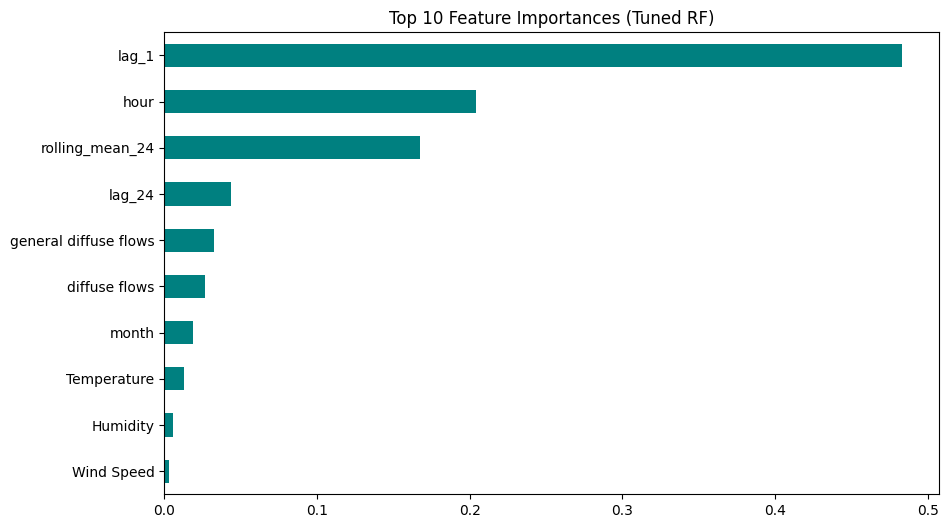

In [9]:
# @title MODEL 2: ADVANCED (Random Forest + TUNING)
print("[Model 2] Tuning Random Forest with RandomizedSearchCV")

# Parameter Grid
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4, 8],
    'max_features': ['sqrt', 'log2']
}

# Inisialisasi & Search
rf_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=RANDOM_STATE,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit
start_time_rf = time.time()
rf_random.fit(X_train_scaled, y_train)
train_time_rf = time.time() - start_time_rf

print(f"Tuning finished in {train_time_rf:.2f} seconds.")
print(f"Best Parameters: {rf_random.best_params_}")

# Evaluasi
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf['Training Time'] = train_time_rf # Simpan waktu

results['RandomForest_Tuned'] = metrics_rf
joblib.dump(best_rf, MODELS_DIR / "model_rf.pkl")

print("-" * 30)
print(f"Random Forest RMSE    : {metrics_rf['RMSE']:.2f}")
print(f"Random Forest MAE     : {metrics_rf['MAE']:.2f}")
print(f"Random Forest R2 Score: {metrics_rf['R2']:.2f}")
print("-" * 30)

# Visualisasi Feature Importance
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Feature Importances (Tuned RF)")
plt.gca().invert_yaxis()
save_plot(plt.gcf(), "model_rf_feature_importance.png")
plt.show()

[Model 3] Training Deep Learning (MLP)

[Info] Deep Learning Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,289 (173.00 KB)

 Trainable params: 44,289 (173.00 KB)

 Non-trainable params: 0 (0.00 B)


[Info] Starting Training
Epoch 1/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 946859328.0000 - mae: 29040.5293 - val_loss: 50995232.0000 - val_mae: 6075.5317 - learning_rate: 0.0010
Epoch 2/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 42175024.0000 - mae: 5248.1851 - val_loss: 13300744.0000 - val_mae: 3012.7527 - learning_rate: 0.0010
Epoch 3/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 20871854.0000 - mae: 3624.7344 - val_loss: 7702890.0000 - val_mae: 2247.8523 - learning_rate: 0.0010
Epoch 4/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13880315.0000 - mae: 2955.4026 - val_loss: 4776874.0000 - val_mae: 1737.3777 - learning_rate: 0.0010
Epoch 5/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 10111190.0000 - mae: 2529.1650 - val_loss: 3160709.5000 - val_mae: 1408.5686 - learning_rate: 0.0010
Epoch 6/40
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8090798.5000 - mae: 2255.7039 - val_loss: 2272723.5000 - val_mae: 1201.4702 - learning_rate: 0.0010
Epoc

Deep Learning RMSE    : 483.14
Deep Learning MAE     : 328.36
Deep Learning R2 Score: 0.99
Plot saved: /content/images/model_dl_training_history.png


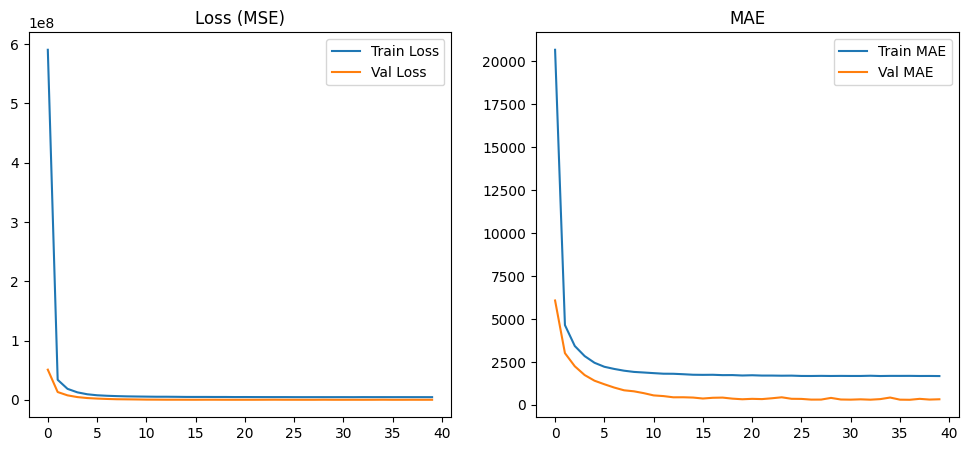

In [10]:
# @title MODEL 3: DEEP LEARNING (MLP + LR Scheduler)

print("[Model 3] Training Deep Learning (MLP)")

# Definisi Arsitektur
model_dl = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

print("\n[Info] Deep Learning Model Architecture:")
model_dl.summary()

# Compile
model_dl.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Catat Waktu Training
print("\n[Info] Starting Training")
start_time_dl = time.time()  # Mulai Stopwatch

history = model_dl.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=40,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Stop Stopwatch & Hitung Durasi
end_time_dl = time.time()
duration_dl = end_time_dl - start_time_dl

print("-" * 40)
print(f"Training Finished.")
print(f"Training Time: {duration_dl:.2f} seconds")
print("-" * 40)

# Evaluasi & Simpan Hasil
y_pred_dl = model_dl.predict(X_test_scaled).flatten()
metrics_dl = regression_metrics(y_test, y_pred_dl)

# Simpan waktu ke dictionary untuk tabel perbandingan
metrics_dl['Training Time'] = duration_dl
results['DeepLearning'] = metrics_dl

model_dl.save(MODELS_DIR / "model_dl_final.h5")

print(f"Deep Learning RMSE    : {metrics_dl['RMSE']:.2f}")
print(f"Deep Learning MAE     : {metrics_dl['MAE']:.2f}")
print(f"Deep Learning R2 Score: {metrics_dl['R2']:.2f}")

# Plot History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE')
plt.legend()
save_plot(plt.gcf(), "model_dl_training_history.png")
plt.show()

[5] Final Evaluation

Model Comparison Table:


,MAE,RMSE,R2,Training Time
Baseline_LR,290.281094,456.533156,0.994521,0.047734
RandomForest_Tuned,658.476381,847.084485,0.981136,208.467154
DeepLearning,328.359489,483.141889,0.993863,82.105623


Plot saved: /content/images/eval_prediction_comparison.png


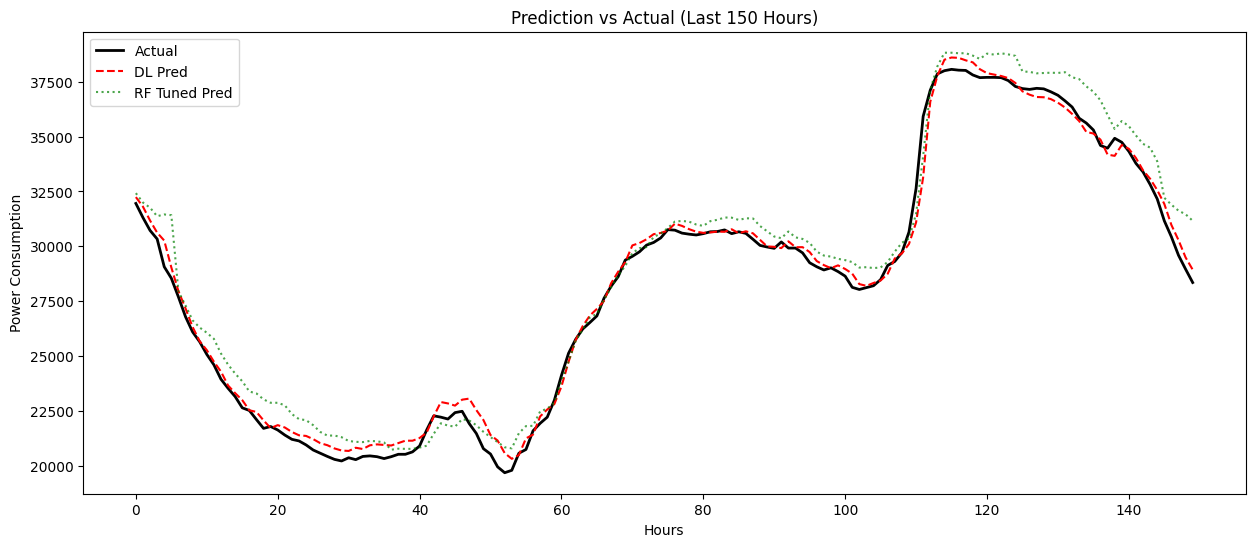

Artifacts saved in /content


In [11]:
# @title EVALUATION & COMPARISON
print("[5] Final Evaluation")

comparison_df = pd.DataFrame(results).T
print("\nModel Comparison Table:")
display(comparison_df)
comparison_df.to_csv(BASE_DIR / "model_comparison_results.csv")

# Visualisasi Prediksi (Zoom-in)
last_n = 150
plt.figure(figsize=(15, 6))
plt.plot(range(last_n), y_test[-last_n:].values, label='Actual', color='black', linewidth=2)
plt.plot(range(last_n), y_pred_dl[-last_n:], label='DL Pred', linestyle='--', color='red')
plt.plot(range(last_n), y_pred_rf[-last_n:], label='RF Tuned Pred', linestyle=':', color='green', alpha=0.7)
plt.title(f"Prediction vs Actual (Last {last_n} Hours)")
plt.xlabel("Hours")
plt.ylabel("Power Consumption")
plt.legend()
save_plot(plt.gcf(), "eval_prediction_comparison.png")
plt.show()

print(f"Artifacts saved in {BASE_DIR}")

Plot saved: /content/images/comparison_error_metrics.png


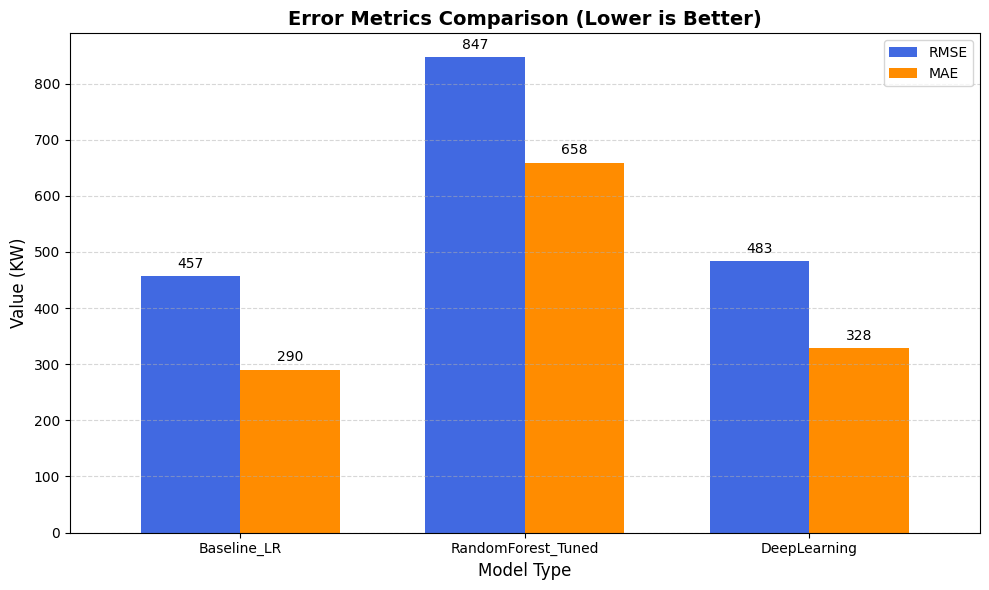

In [12]:
# @title VISUALISASI PERBANDINGAN ERROR METRICS (RMSE & MAE)

comparison_df = pd.DataFrame(results).T

colors_error = ['royalblue', 'darkorange']
color_r2 = ['forestgreen']

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

comparison_df[['RMSE', 'MAE']].plot(kind='bar', ax=ax1, color=colors_error, width=0.7)

plt.title('Error Metrics Comparison (Lower is Better)', fontsize=14, fontweight='bold')
plt.ylabel('Value (KW)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='best')

for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.0f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
save_plot(plt.gcf(), "comparison_error_metrics.png")
plt.show()

Plot saved: /content/images/comparison_r2_score.png


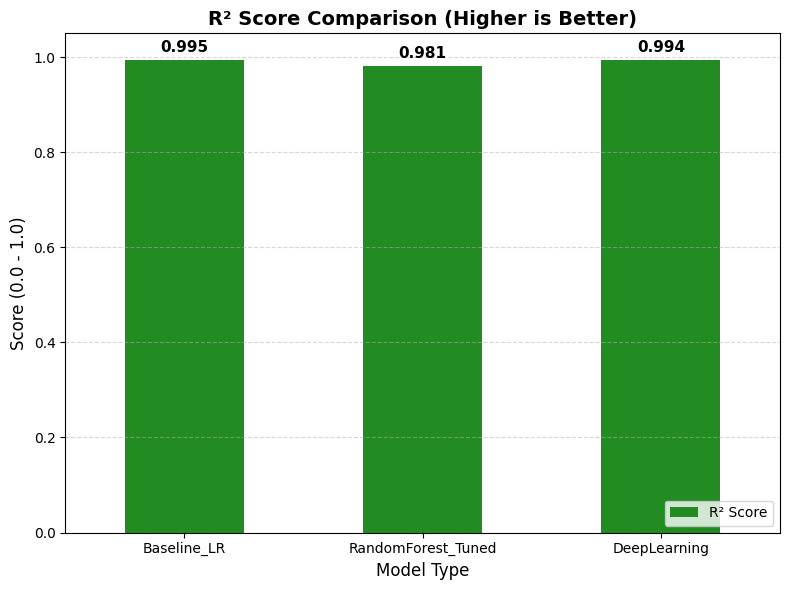

In [13]:
# @title VISUALISASI PERBANDINGAN AKURASI (R2 SCORE)
plt.figure(figsize=(8, 6))
ax2 = plt.gca()

comparison_df[['R2']].plot(kind='bar', ax=ax2, color=color_r2, width=0.5)

plt.title('R² Score Comparison (Higher is Better)', fontsize=14, fontweight='bold')
plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
plt.xlabel('Model Type', fontsize=12)
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(['R² Score'], loc='lower right')

for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.3f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=11, fontweight='bold')

plt.tight_layout()
save_plot(plt.gcf(), "comparison_r2_score.png")
plt.show()

In [14]:
import sys
from importlib.metadata import version
import pandas, numpy, sklearn, matplotlib, seaborn, tensorflow, joblib, xgboost

print(f"Python Version: {sys.version.split()[0]}")
print("-" * 30)
try:
    print(f"ucimlrepo=={version('ucimlrepo')}")
except:
    print("ucimlrepo not found/installed")

print(f"numpy=={numpy.__version__}")
print(f"pandas=={pandas.__version__}")
print(f"scikit-learn=={sklearn.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"seaborn=={seaborn.__version__}")
print(f"tensorflow=={tensorflow.__version__}")
print(f"joblib=={joblib.__version__}")
try:
    print(f"xgboost=={xgboost.__version__}")
except:
    pass

Python Version: 3.12.12
------------------------------
ucimlrepo==0.0.7
numpy==2.0.2
pandas==2.2.2
scikit-learn==1.6.1
matplotlib==3.10.0
seaborn==0.13.2
tensorflow==2.19.0
joblib==1.5.2
xgboost==3.1.2
